# Imports
## Libraries

In [1]:
import numpy as np
import os
import cv2
import xml.etree
import xml.etree.ElementTree
import tensorflow as tf

tf.compat.v1.disable_eager_execution()


## Mask RCNN imports

In [2]:
import mrcnn.utils
import mrcnn.config
import mrcnn.model
import mrcnn.visualize


# Dataset

In [3]:
class TomatoDataset(mrcnn.utils.Dataset):

    def load_dataset(self, dataset_dir, class_name, is_train=True):
        self.class_name = class_name
        self.add_class("dataset", 1, self.class_name)
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annotations/'
        for filename in os.listdir(images_dir):
            image_id = filename[6:-4]

            if is_train and int(image_id) >= 700:
                continue

            if not is_train and int(image_id) < 700:
                continue

            img_path = images_dir + filename
            ann_path = annotations_dir + filename[:-4] + '.xml'

            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
        
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']
        boxes, w, h = self.extract_boxes(path)
        masks = np.zeros([h, w, len(boxes)], dtype='uint8')

        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index(self.class_name))
        return masks, np.asarray(class_ids, dtype='int32')
    
    def extract_boxes(self, filename):
        tree = xml.etree.ElementTree.parse(filename)

        root = tree.getroot()

        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)

        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height


# Config

In [4]:
class TomatoConfig(mrcnn.config.Config):
    NAME = "tomato_cfg"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    NUM_CLASSES = 2

    STEPS_PER_EPOCH = 50

# Dataset Preparation

In [5]:
dataset = TomatoDataset()
dataset.load_dataset(
    dataset_dir='tomatoes',
    class_name='tomato',
    is_train=True)
dataset.prepare()
config = TomatoConfig()

validation_dataset = TomatoDataset()
validation_dataset.load_dataset(
    dataset_dir='tomatoes',
    class_name='tomato',
    is_train=False)
validation_dataset.prepare()

# Training

In [6]:
model = mrcnn.model.MaskRCNN(mode='training', 
                             model_dir='./', 
                             config=config)
model.load_weights(filepath='mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [7]:
train = True ## Set to False if you want to load the trained model
if train:
    model.train(train_dataset=dataset, 
                val_dataset=validation_dataset, 
                learning_rate=config.LEARNING_RATE, 
                epochs=1, 
                layers='heads')
    model_path = 'tomato_mask_rcnn_trained.h5'
    model.keras_model.save_weights(model_path)


Starting at epoch 0. LR=0.001

Checkpoint Path: ./tomato_cfg20230226T1608\mask_rcnn_tomato_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistribute

c:\Users\razma\Projects\tomatos\venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


50/50 [==============================] - ETA: 0s - batch: 24.5000 - size: 1.0000 - loss: 23.4108 - rpn_class_loss: 3.6189 - rpn_bbox_loss: 18.7296 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.9977 - mrcnn_mask_loss: 0.0350 

c:\Users\razma\Projects\tomatos\venv\lib\site-packages\keras\engine\training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


50/50 [==============================] - 835s 17s/step - batch: 24.5000 - size: 1.0000 - loss: 23.4108 - rpn_class_loss: 3.6189 - rpn_bbox_loss: 18.7296 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.9977 - mrcnn_mask_loss: 0.0350 - val_loss: 18.3728 - val_rpn_class_loss: 2.7285 - val_rpn_bbox_loss: 13.0263 - val_mrcnn_class_loss: 0.0322 - val_mrcnn_bbox_loss: 2.5842 - val_mrcnn_mask_loss: 0.0017


# Prediction

Instructions for updating:
Use fn_output_signature instead


c:\Users\razma\Projects\tomatos\venv\lib\site-packages\keras\engine\training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


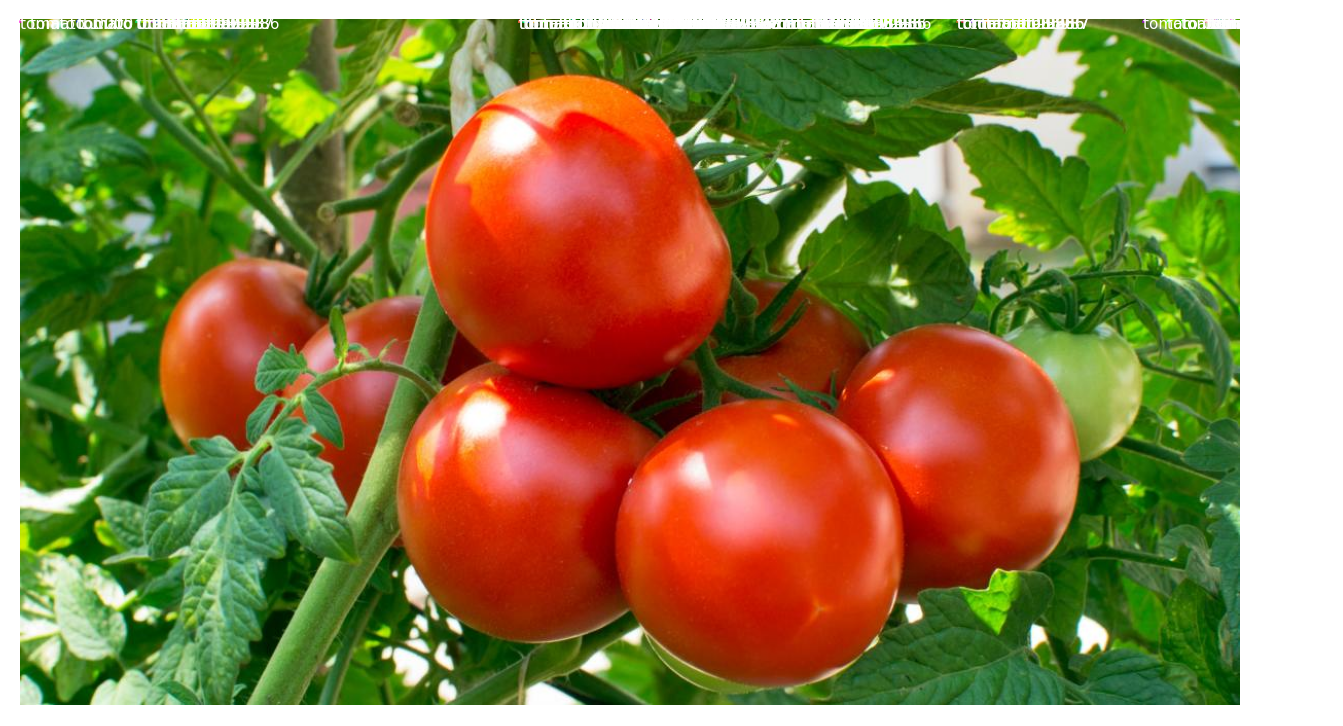

In [8]:
CLASS_NAMES = ['BG', 'tomato']
class SimpleConfig(mrcnn.config.Config):
    # Give the configuration a recognizable name
    NAME = "coco_inference"
    
    # set the number of GPUs to use along with the number of images per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

	# Number of classes = number of classes + 1 (+1 for the background). The background class is named BG
    NUM_CLASSES = len(CLASS_NAMES)

# Initialize the Mask R-CNN model for inference and then load the weights.
# This step builds the Keras model architecture.
model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

# Load the weights into the model.
model.load_weights(filepath="tomato_mask_rcnn_trained.h5", 
                   by_name=True)

# load the input image, convert it from BGR to RGB channel
image = cv2.imread("sample2.jpeg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform a forward pass of the network to obtain the results
r = model.detect([image], verbose=0)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
mrcnn.visualize.display_instances(image=image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'], 
                                  class_names=CLASS_NAMES, 
                                  scores=r['scores'])
